# Macro Regimes


## 4
We are looking at the ISM manufacturing index and the fed funds rate as our economic indicators. The ISM manufacturing index is a survey that tracks manufacturing activity within several industries. As an indicator it tells us about growth and econimic activity. Higher readings should indicate high growth, leading to higher equities prices. They can also be an indicator of future inflation which would drive up yields. I would also expect higher readings to increase commodities prices, as they may suggest higher short term demand for fuel and materials. The Fed Funds rate affects the risk free rate which has an impact across all asset prices. Higher fed funds rates directly affect yields, driving them higher. It also affects equities by changing the discount rate, which has an inverse affect on equities prices. Higher rates also have the effect of reducing economic activity as it gets more expensive for companies to invest in new projects. Due to the reduction of economic activity, I would expect higher rates to reduce commodities prices, as the lower activity would mean less demand for commodities in the short term.

## 5

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

FILE1             = "Assignment_2_data.xlsm"
FILE3             = "macro_data_TR-fixed.xlsx"
ANNUAL_FACTOR = 252

In [68]:
# Fed Funds (EFFR)
fed = pd.read_excel(FILE1, sheet_name='FF', index_col='Date')
fed = fed[~fed.index.duplicated(keep='last')]

fed = (fed            # daily EFFR
           .resample('ME').mean()      # calendar‑month mean
           .asfreq('B', method='ffill')  # fill forward to biz days
           [fed.index.min():])   # trim to asset window

# def rolling_slope(y_window):
#     # y_window is a 1‑D array of length window=12
#     # we regress y = a + b·t  on t = 0,1,...,11
#     b, a = np.polyfit(np.arange(len(y_window)), y_window, 1)
#     return b
fed['rates_slope'] = fed['Rate'].diff(252)

# Label regimes: 0, flat rates, -1, decreasing rates, 1, increasing rates
fed['regime'] = np.where(fed['rates_slope']<-0.5, -1, np.where(fed['rates_slope']>0.5, 1, 0))
n = 126
fed['segment'] = (fed['regime'] != fed['regime'].shift(1)).cumsum()
fed['seg_size'] = fed.groupby('segment')['regime'].transform('size')
mask = (fed['seg_size']< n) & (fed['regime'] != 0)
fed.loc[mask, 'regime'] = 0


def max_drawdown(prices):
    """Given a price series, compute the maximum drawdown."""
    running_max = prices.cummax()
    drawdown = (prices - running_max) / running_max
    return drawdown.min()  # most negative value

# Fed Funds (EFFR)
ism = pd.read_excel(FILE1, sheet_name='ISM', index_col='Date')
ism = ism[~ism.index.duplicated(keep='last')]

ism = (ism            # daily EFFR
           .resample('ME').mean()      # calendar‑month mean
           .asfreq('B', method='ffill')  # fill forward to biz days
           [ism.index.min():])   # trim to asset window

spx = pd.read_excel(FILE1, sheet_name='SPTX', index_col='Date')
spx.rename(columns={'Price': 'SPX'}, inplace=True)
spx = spx[~spx.index.duplicated(keep='last')]
spx = spx[spx['SPX']>5]

treasury = pd.read_excel(FILE3, sheet_name='LUATTRUU', index_col='Date')
treasury = treasury[~treasury.index.duplicated(keep='last')]
treasury.rename(columns = {"PX_Last": "tbonds"}, inplace=True)


hy = pd.read_excel(FILE3, sheet_name='H0A0', index_col='Date')
hy = hy[~hy.index.duplicated(keep='last')]
hy.rename(columns = {"PX_Last":"hy"}, inplace=True)

# Commodities & Gold
commodities = pd.read_excel(FILE3, sheet_name='BCOMTR', index_col='Date')
commodities = commodities[~commodities.index.duplicated(keep='last')]
commodities.rename(columns = {'PX_Last': "com"}, inplace=True)




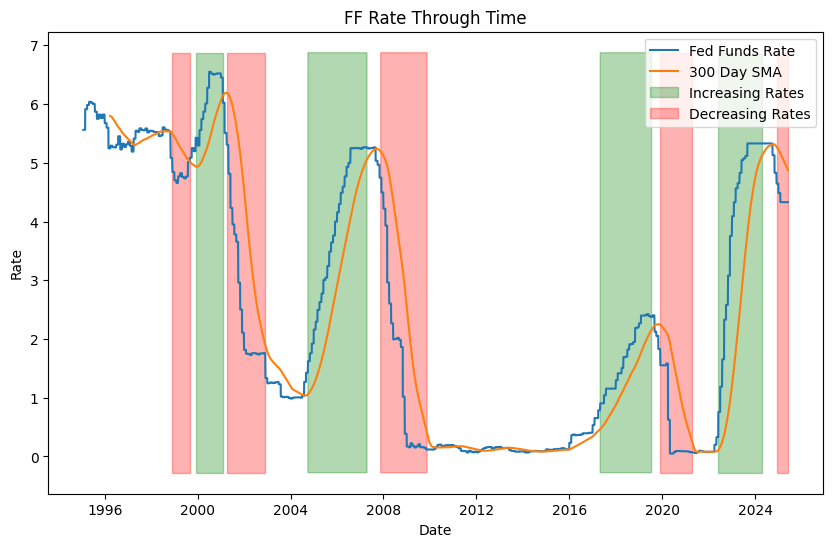

In [71]:
fig, ax = plt.subplots(figsize = (10, 6))
ax.plot(fed['Rate'], label = 'Fed Funds Rate')
ax.plot(fed['Rate'].rolling(window = 300).mean(), label = '300 Day SMA')
ymin, ymax = ax.get_ylim()
ax.fill_between(fed.index, ymin, ymax,
                where = (fed['regime']==1),
                color = "green", alpha = 0.3,
                label = "Increasing Rates")
ax.fill_between(fed.index, ymin, ymax,
                where = (fed['regime']==-1),
                color = "red", alpha = 0.3,
                label = "Decreasing Rates")
ax.set_xlabel("Date")
ax.set_ylabel('Rate')
plt.legend(loc = 'upper right')
plt.title("FF Rate Through Time")
plt.show()

In [67]:
fed['spx'] = spx['SPX'].pct_change()
fed['com'] = commodities['com'].pct_change()
fed['hy'] = hy['hy'].pct_change()
fed['tr'] = treasury['tbonds'].pct_change()
asset_cols = ['spx', 'com', 'hy', 'tr']

results = []
for (regime, seg_id), group in fed.groupby(['regime', 'segment']):
    spx = group['spx'].dropna()
    hy = group['hy'].dropna()
    com = group['com'].dropna()
    tr = group['tr'].dropna()

    spx_avg_ret = spx.mean() * ANNUAL_FACTOR
    spx_vol = spx.std() * np.sqrt(ANNUAL_FACTOR)

    hy_avg_ret = hy.mean() * ANNUAL_FACTOR
    hy_vol = hy.std() * np.sqrt(ANNUAL_FACTOR)

    com_avg_ret = com.mean() * ANNUAL_FACTOR
    com_vol = com.std() * np.sqrt(ANNUAL_FACTOR)

    tr_avg_ret = tr.mean() * ANNUAL_FACTOR
    tr_vol = tr.std() * np.sqrt(ANNUAL_FACTOR)

    duration = len(group)
    if duration < 50:
        continue


    results.append({
        'regime': regime,
        'segment': seg_id,
        'start' : group.index.min(),
        'end': group.index.max(),
        'days': duration,
        'equities avg returns': spx_avg_ret,
        'equities vol': spx_vol,
        'high yield avg returns': hy_avg_ret,
        'high yield vol': hy_vol,
        'commodities avg returns': com_avg_ret,
        'commodities vol': com_vol,
        'treasuries avg returns': tr_avg_ret,
        'treasuries vol': tr_vol
    })

metrics_df = pd.DataFrame(results).set_index(['regime', 'segment'])
metrics_df


start        end  days  equities avg returns  \
regime segment                                                     
-1     8       1998-11-30 1999-08-30   196              0.170217   
       12      2001-04-02 2002-11-18   426             -0.111266   
       24      2007-11-19 2009-11-17   522             -0.050937   
       28      2019-12-02 2021-04-16   360              0.272939   
       32      2024-12-02 2025-05-30   130             -0.250757   
 0     1       1995-01-31 1996-02-28   282              0.324472   
       2       1996-02-29 1996-07-30   109             -0.006364   
       7       1996-12-18 1998-11-27   508              0.289582   
       9       1999-08-31 1999-11-29    65              0.275433   
       17      2003-01-31 2003-04-16    54              0.239928   
       20      2003-06-30 2003-11-18   102              0.171553   
       21      2003-11-19 2004-09-29   226              0.111028   
       23      2007-04-18 2007-11-16   153              0.018196   
       25      2009-11-18 2017-04-28  1943              0.135549   
       27      2019-07-18 2019-11-29    97              0.165087   
       29      2021-04-19 2022-05-30   291              0.023909   
       31      2024-04-17 2024-11-29   163              0.305039   
 1     10      1999-11-30 2001-01-30   306              0.013975   
       22      2004-09-30 2007-04-17   664              0.133250   
       26      2017-05-01 2019-07-17   578              0.130730   
       30      2022-05-31 2024-04-16   491              0.135074   

                equities vol  high yield avg returns  high yield vol  \
regime segment                                                         
-1     8            0.188139                0.023279        0.019066   
       12           0.239594               -0.042755        0.056502   
       24           0.351060                0.063284        0.093305   
       28           0.302812                0.074284        0.097124   
       32           0.151343                0.022558        0.043149   
 0     1            0.088199                0.177086        0.021141   
       2            0.125735                0.028894        0.035561   
       7            0.190895                0.079784        0.028034   
       9            0.188123                0.000537        0.016315   
       17           0.225667                0.314591        0.030062   
       20           0.131055                0.135040        0.030054   
       21           0.112298                0.098155        0.026103   
       23           0.167888               -0.026170        0.037989   
       25           0.152164                0.079974        0.038571   
       27           0.137457                0.040256        0.025557   
       29           0.175960               -0.039791        0.042606   
       31           0.129368                0.133074        0.025978   
 1     10           0.218000                0.009679        0.028876   
       22           0.103489                0.082243        0.021354   
       26           0.134599                0.047924        0.027765   
       30           0.171834                0.044820        0.061481   

                commodities avg returns  commodities vol  \
regime segment                                             
-1     8                       0.133164         0.126939   
       12                      0.024546         0.134246   
       24                     -0.096531         0.270621   
       28                      0.100329         0.157579   
       32                      0.126109         0.138301   
 0     1                       0.164259         0.077675   
       2                       0.177150         0.107024   
       7                      -0.146453         0.104683   
       9                       0.243840         0.148210   
       17                     -0.191510         0.155705   
       20                      0.318548         0.115733   
       21         

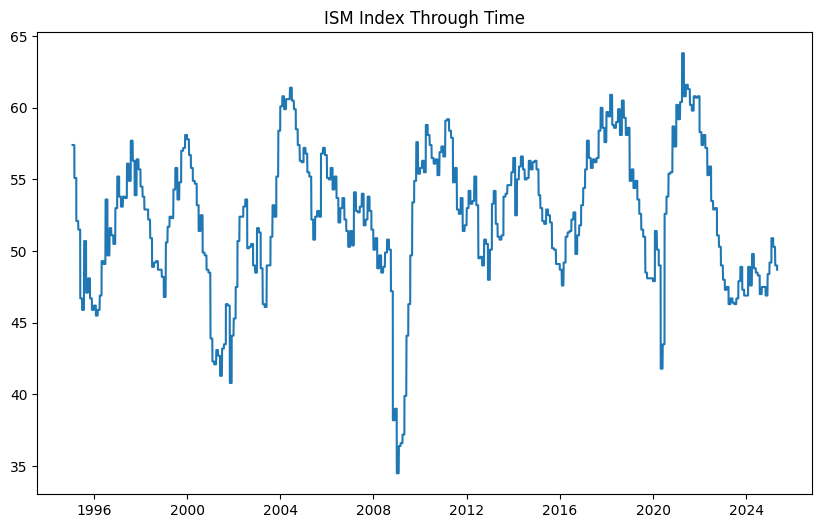

In [11]:
plt.figure(figsize = (10, 6))
plt.plot(ism['ISM'])
plt.title("ISM Index Through Time")
plt.show()